# Physics 494/594
## Gradient of a Neural Network

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
import jax.numpy as jnp 
from jax import grad
from jax import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
π = np.pi

## Last Time

### [Notebook Link: 14_Stochastic_Gradient_Descent.ipynb](./14_Stochastic_Gradient_Descent.ipynb)

- Use randomness to effeciently optimize a rough convex function
- Minibatches (data subsets) and epochs (all possible minibatches)

## Today

- Taking the gradient of a neural network.

In lecture, we manually determined the gradient of the cost function of a shallow neural network with 2 input neurons and one output.

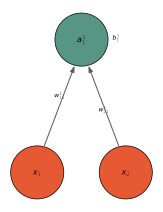

In [2]:
ml4s.draw_network([2,1], zero_index=False )

## Cost & Gradient

For a data set: $\mathcal{D} = \left\{\vec{x}^{(n)},y^{(n)}\right\}_{n=1}^{N}$, we wrote the cost function as the usual least squared error:

\begin{equation}
C\left(w_{11}^1,w_{21}^1,b_1^1; \mathcal{D}\right) = \frac{1}{2} \langle \left(a_1^1 - y\right)^2 \rangle
\end{equation}

where $\langle \dots \rangle$ indicates an average over $\mathcal{D}$.  By using the chain rule we found:

\begin{align}
\frac{\partial C}{\partial w_{j1}^1} &= \langle \left(a_1^1 - y\right)f^\prime\left(z_1^1\right)x_j  \rangle \\
\frac{\partial C}{\partial b_{1}^1} &= \langle \left(a_1^1 - y\right)f^\prime\left(z_1^1\right) \rangle \, .
\end{align}

Let's assume our non-linearity is a sigmoid:

\begin{equation}
f(z) = \sigma(z) = \frac{1}{1+e^{-z}}
\end{equation}

such that the derivative will be:
\begin{equation}
f^\prime(z) = \frac{e^{-z}}{\left(1+e^{-z}\right)^2}.
\end{equation}

I will use `jax.numpy` for these functions as a drop-in replacement for `numpy`.

In [3]:
def σ(z):
    return 1.0/(1.0 + jnp.exp(-z))

def σ_prime(z):
    return jnp.exp(-z)/(1.0 + jnp.exp(-z))**2

## Feed Forward

The prediction of our network is a sipmle 1-line funciton (we have a shallow network with no hidden layers).

In [4]:
def feed_forward(w, b, x):
    return σ(jnp.dot(x, w) + b)

## A synthetic data set

We will just check the accuracy of our derivative method, so we generate a random (synthetic) data set.

In [5]:
batchsize = 10
x = np.random.uniform(low=-1,high=1,size=[batchsize,2])
y = np.random.uniform(low=-2,high=2,size=[batchsize,])

## Initializing the Network

As we have done in the past, let's start with some random weights and biases.

In [6]:
w = np.random.uniform(low=-1,high=1,size=[2])
b = np.random.uniform(low=-1,high=1,size=1)

## The cost function

\begin{equation}
C\left(w_{11}^1,w_{21}^1,b_1^1; \mathcal{D}\right) = \frac{1}{2} \langle \left(a_1^1 - y\right)^2 \rangle
\end{equation}

In [49]:
z1 = jnp.dot(x, w) + b
a1 = σ(z1)
print(a1)

[0.30652228 0.13503586 0.14788567 0.15833661 0.42197007 0.31925666 0.17397083 0.3474902  0.42469484 0.49320963]


In [8]:
def cost(w,b,x,y):
    a1 = feed_forward(w,b,x)
    return 0.5*jnp.average((a1-y)**2)

In [46]:
cost(w,b,x,y)

DeviceArray(1.0835954, dtype=float32)

## Gradient of the cost function

\begin{align}
\frac{\partial C}{\partial w_{j1}^1} &= \langle \left(a_1^1 - y\right)f^\prime\left(z_1^1\right)x_j  \rangle \\
\frac{\partial C}{\partial b_{1}^1} &= \langle \left(a_1^1 - y\right)f^\prime\left(z_1^1\right) \rangle \, .
\end{align}

In [10]:
def dC_dw(w,b,x,y):
    z1 = jnp.dot(x, w) + b
    a1 = σ(z1)
    fp = σ_prime(z1)
    return jnp.dot((a1-y)*fp, x) / x.shape[0]

def dC_db(w,b,x,y):
    z1 = jnp.dot(x, w) + b
    a1 = σ(z1)
    fp = σ_prime(z1)
    return jnp.average((a1-y)*fp)

### Investigate the output

In [11]:
dCw = dC_dw(w,b,x,y)
ml4s.mdtex(rf'$\nabla_w C = [{dCw[0]:.6f},\, {dCw[1]:.6f}]$')
dCb = dC_db(w,b,x,y)
ml4s.mdtex(rf'$\nabla_b C = {dCb:.6f}$')

$\nabla_w C = [0.027084,\, -0.044622]$

$\nabla_b C = 0.189344$

### Check that these gradients will allow us to step down hill

In [45]:
print(f'cost before: {cost(w,b,x,y):.6f}')
η = 0.9
w -= η*dC_dw(w,b,x,y)
b -= η*dC_db(w,b,x,y)
print(f'cost after: {cost(w,b,x,y):.6f}')

cost before: 1.098169
cost after: 1.083595


### It Works!

---

<div class="span alert alert-success">
<h2> Programming Excercise </h2>
    
<ol>
    <li>Check that our hand-coded gradients are correct using <code>jax</code>.
    <li> Iterate over <code>num_iter = 100</code> simple gradient descent steps and plot the resulting cost vs. iteration. What do you see?
    </li>
</ol>
</div>

In [76]:
w = np.random.uniform(low=-1,high=1,size=[2])
b = np.random.uniform(low=-1,high=1,size=1)
gradwC = grad(cost,argnums=0)
gradbC = grad(cost,argnums=1)

### Compare the results

In [77]:
print(dC_dw(w,b,x,y), gradwC(w,b,x,y), "for random w and b, both functions return the same values")

[ 0.03440846 -0.03402492] [ 0.03440845 -0.03402492] for random w and b, both functions return the same values


In [78]:
print(dC_db(w,b,x,y), gradbC(w,b,x,y), "once again we affirm that the gradient is correct")

0.22605197 [0.22605197] once again we affirm that the gradient is correct


### Track the reduction in cost

In [79]:
η = 0.9
num_iter = 100

C = []
for n in range(num_iter):
    w -= η*dC_dw(w,b,x,y)
    b -= η*dC_db(w,b,x,y)
    C.append(cost(w,b,x,y))

### Plot the result

Text(0, 0.5, 'Cost')

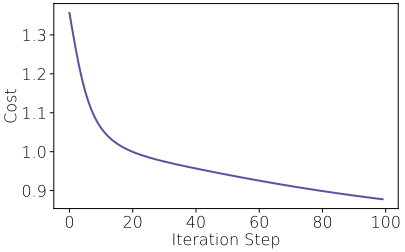

In [80]:
plt.plot(C)
plt.xlabel('Iteration Step')
plt.ylabel('Cost')